# Manual validation results
This notebook calculates the results of the manual validation by four raters.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tueplots import bundles
plt.rcParams.update(bundles.icml2022())

In [2]:
ana = pd.read_excel("../dat/validation/deps_to_validate_ana.xlsx")
hanqi = pd.read_excel("../dat/validation/deps_to_validate_hanqi.xlsx")
dom = pd.read_excel("../dat/validation/deps_to_validate_Dom.xlsx")
atc = pd.read_excel("../dat/validation/deps-all-validated-ATC.xlsx")

In [3]:
atc = atc.sort_values(atc.columns[0]).reset_index()

In [4]:
source = pd.read_csv("../dat/validation/source_column.csv")

In [5]:
ratings = pd.DataFrame({"source": source["source"],
                        "rater1": ana.iloc[:,3],
                        "rater2": hanqi.iloc[:,3],
                        "rater3": dom.iloc[:,3],
                        "rater4": atc.iloc[:,4]}).replace(-1, 0).replace("D", 0).replace("?", 0)

In [6]:
# drop old wiki preds that are not there anymore after mistake correction
dropped = [('Equivalence relation', 'Transitive relation'),
 ('Substitution (logic)', 'Formal language'),
 ('Polynomial ring', 'Polynomial'),
 ('Matrix addition', 'Addition'),
 ('Set (mathematics)', 'Empty set'),
 ('Mathematics', 'Mathematical analysis'),
 ('Empty set', 'Axiomatic set theories')]
ids = [list(dom.loc[(dom.concept==concept) & (dom.dependency==dep),"Unnamed: 0"])[0] for concept, dep in dropped]
ratings = ratings.drop(ids)

In [7]:
def kappa(ratings1, ratings2, chance=0.25):
    agree = 1-np.mean((ratings1-ratings2)**2)
    return round((agree-chance)/(1-chance),2)

print([kappa(ratings.iloc[:,1], ratings.iloc[:,2]),
kappa(ratings.iloc[:,1], ratings.iloc[:,3]),
kappa(ratings.iloc[:,2], ratings.iloc[:,3]),
kappa(ratings.iloc[:,1], ratings.iloc[:,4]),
kappa(ratings.iloc[:,2], ratings.iloc[:,4]),
kappa(ratings.iloc[:,3], ratings.iloc[:,4]),])

[0.59, 0.75, 0.69, 0.69, 0.67, 0.76]


In [8]:
ratings_summary = round(ratings.groupby("source").mean()*100,2)
ratings_summary.index = ["T0pp","Textbooks","Wikipedia"]
ratings_summary.columns = ["Rater 1", "Rater 2", "Rater 3", "Rater 4"]
ratings_summary

,Rater 1,Rater 2,Rater 3,Rater 4
T0pp,33.00,64.00,48.00,42.00
Textbooks,33.00,45.00,37.00,33.00
Wikipedia,64.52,73.12,78.49,84.78


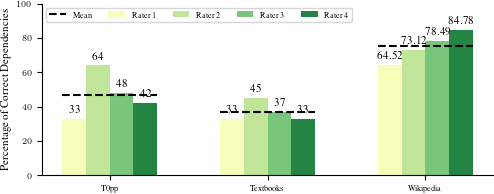

In [9]:
fig, ax = plt.subplots(layout='constrained', figsize=(5,2))

width = 0.15  # the width of the bars
multiplier = 0

x = np.arange(ratings_summary.shape[0])
colors=["#f7fcb9","#c2e699","#78c679","#238443"]
for rater in ratings_summary.columns:
    offset = width * multiplier
    rects = ax.bar(x + offset, ratings_summary[rater], width, label=rater, color=colors[multiplier])
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage of Correct Dependencies')
ax.set_xticks(x + 1.5*width, ratings_summary.index)
ax.set_ylim(0, 100)
ax.spines[['right', 'top']].set_visible(False)

plt.hlines(ratings_summary.mean(axis=1), 
           xmin=[0-0.5*width,1-0.5*width,2-0.5*width], 
           xmax=[0+3.5*width,1+3.5*width,2+3.5*width],
           color="black", linestyles='dashed',label="Mean")
ax.legend(loc='upper left', ncols=5)
plt.show()
fig.savefig("../doc/img/rating.pdf", format="pdf")

In [10]:
ratings_summary.mean(axis=1)

T0pp         46.7500
Textbooks    37.0000
Wikipedia    75.2275
dtype: float64

In [11]:
import plotly.express as px
N=4
kappa_coefs = [[kappa(ratings.iloc[:,i+1], ratings.iloc[:,j+1]) for j in range(N) ] for i in range (N)]
kappa_coefs = [[None, 0.6, 0.75, 0.7], [None, None, 0.68, 0.67], [None, None, None, 0.76], [None, None, None, None]]
fig = px.imshow(kappa_coefs, text_auto=True, labels=dict(color="Kappa coefficient"),
                x=['Rater 1', 'Rater 2', 'Rater 3', 'Rater 4'],
                y=['Rater 1', 'Rater 2', 'Rater 3', 'Rater 4'],
                color_continuous_scale='RdYlGn',range_color=(0,1)
                )
fig.update_layout({
"plot_bgcolor": "rgba(0, 0, 0, 0)",
"paper_bgcolor": "rgba(0, 0, 0, 0)",
"font": dict(size=20)
})
fig.update_coloraxes(showscale=False)
fig.show()

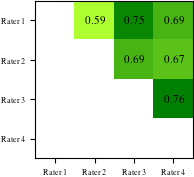

In [12]:
import matplotlib.colors
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["greenyellow","green"])

N=4
kappa_coefs = np.array([[kappa(ratings.iloc[:,i+1], ratings.iloc[:,j+1]) for j in range(N) ] for i in range (N)])
mask =  np.tri(kappa_coefs.shape[0], k=0)
A = np.ma.array(kappa_coefs, mask=mask)

fig, ax = plt.subplots(figsize=(2,2))
im = ax.imshow(A,cmap=cmap)
ax.set_xticks(np.arange(N), labels=["Rater 1","Rater 2","Rater 3","Rater 4"])
ax.set_yticks(np.arange(N), labels=["Rater 1","Rater 2","Rater 3","Rater 4"])

for i in range(N):
    for j in range(N):
        if j > i:
            text = ax.text(j, i, A[i, j],
                       ha="center", va="center", color="black")
            
plt.show()
fig.savefig("../doc/img/kappa.pdf", format="pdf")